In [2]:
import google.datalab.ml as ml
import json
import math
import matplotlib.pyplot as plot
import mltoolbox.regression.dnn as regression
import numpy as np
import pandas as pd
import os
import seaborn as sns
import sklearn.metrics as metrics

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#string to hold the path
workspace_path = '/content/datalab/workspace/census'

make a directory with name created above:

In [4]:
!mkdir -p {workspace_path}

In [5]:
#!gsutil -q cp gs://cloud-datalab-samples/census/ss14psd.csv {workspace_path}/data/census.csv
!gsutil -q cp gs://cloud-datalab-samples/census/ss14psd.csv {workspace_path}/data/census.csv

In [6]:
!ls -l {workspace_path}/data   #check the contents of folder

total 8204
-rw-r--r-- 1 root root 8189323 Jul  1 11:53 census.csv
-rw-r--r-- 1 root root   39989 Jun 30 12:10 eval.csv
-rw-r--r-- 1 root root     998 Jun 30 12:10 schema.json
-rw-r--r-- 1 root root  163566 Jun 30 12:10 train.csv


In [7]:
df_data = pd.read_csv(os.path.join(workspace_path, 'data/census.csv'), dtype=str)

In [8]:
print '%d rows' % len(df_data)
print df_data.head()

8626 rows
  RT SERIALNO SPORDER   PUMA  ST   ADJINC  PWGTP AGEP CIT CITWP   ...    \
0  P       25      01  00400  46  1008425  00038   85   1         ...     
1  P      467      01  00600  46  1008425  00120   62   1         ...     
2  P      490      01  00500  46  1008425  00172   64   1         ...     
3  P      490      02  00500  46  1008425  00113   67   1         ...     
4  P      676      01  00300  46  1008425  00023   89   1         ...     

  pwgtp71 pwgtp72 pwgtp73 pwgtp74 pwgtp75 pwgtp76 pwgtp77 pwgtp78 pwgtp79  \
0   00011   00010   00008   00032   00040   00038   00033   00040   00068   
1   00119   00039   00034   00119   00125   00104   00119   00102   00184   
2   00049   00045   00148   00163   00313   00174   00153   00165   00158   
3   00037   00032   00107   00125   00249   00107   00105   00094   00091   
4   00022   00006   00035   00030   00028   00027   00020   00042   00019   

  pwgtp80  
0   00090  
1   00038  
2   00126  
3   00079  
4   00011  

[5 

function to make data usable (and re-usable). Strip out columns that we don't need and keep the ones we do.

In [9]:
def transform_data(df):
  interesting_columns = ['WAGP','SERIALNO','AGEP','COW','ESP','ESR','FOD1P','HINS4','INDP',
                         'JWMNP', 'JWTR', 'MAR', 'POWPUMA', 'PUMA', 'RAC1P', 'SCHL',
                         'SCIENGRLP', 'SEX', 'WKW']
  df = df[interesting_columns]
 
  #replace whitespace with NaN, and NaN with empty string
  df = df.replace('\s+', np.nan, regex=True).fillna('')

  #drop wages column that are empty
  df = df[df.WAGP != '']
  #divide wages by 1000 to make #s smaller for easier calculation
  df['WAGP'] = df.WAGP.astype(np.int64) / 1000.0
  
  #take out outliers / extreme wages on either end of scale - wages >= $10k and < $150k
  df = df[(df.WAGP >= 10.0) & (df.WAGP < 150.0)]
  
  #return the function value - the dataframe, now cleaned and made usable
  return df

In [10]:
df_data = transform_data(df_data)
print '%d rows' % len(df_data)
df_data.head()

3390 rows


,WAGP,SERIALNO,AGEP,COW,ESP,ESR,FOD1P,HINS4,INDP,JWMNP,JWTR,MAR,POWPUMA,PUMA,RAC1P,SCHL,SCIENGRLP,SEX,WKW
1,70.0,467,62,1,,1,2102,2,6990,015,01,3,00590,00600,1,21,2,1,1
2,19.0,490,64,2,,1,,2,8090,015,01,1,00590,00500,1,18,,2,1
6,70.0,1225,32,5,,4,5301,2,9680,015,01,1,00100,00100,1,21,2,1,1
7,18.0,1225,30,1,,1,,2,8680,020,01,1,00100,00100,1,16,,2,1
11,45.0,1438,55,1,,1,,2,6170,030,01,1,00100,00100,1,16,,1,1


## Prepare Datasets for testing and training
Split the dataset into training and testing sets (80% for training, 20% for testing / evaluating)
Make the schema reusable

In [11]:
#setup functions to call for creating a schema and to split dataset into training and eval sets
#create a schema for reuse
def create_schema(df):
  fields = []
  for name, dtype in zip(df.columns, df.dtypes):
    if dtype in (np.str, np.object):
      # Categorical columns should have type 'STRING'
      fields.append({'name': name, 'type': 'STRING'})
    elif dtype in (np.int32, np.int64, np.float32, np.float64):
      # Numerical columns have type 'FLOAT'
      fields.append({'name': name, 'type': 'FLOAT'})
    else:
      raise ValueError('Unsupported column type "%s" in column "%s"' % (str(dtype), name))
  return fields

#create the training and evaluation sets
def create_datasets(df):
  random_values = np.random.rand(len(df))
  
  df_train = df[random_values < 0.8]
  df_eval =  df[random_values >= 0.8]
  
  return df_train, df_eval

In [12]:
# call the functions to create sets and schema
df_train, df_eval = create_datasets(df_data)
schema = create_schema(df_data)

#set the path and files
training_data_path = os.path.join(workspace_path, 'data/train.csv')
eval_data_path = os.path.join(workspace_path, 'data/eval.csv')
schema_path = os.path.join(workspace_path, 'data/schema.json')

#convert the files to csv
df_train.to_csv(training_data_path, header=False, index=False)
df_eval.to_csv(eval_data_path, header=False, index=False)

#write the schema json file
with open(schema_path, 'w') as f:
  f.write(json.dumps(schema, indent=2))


In [13]:
!ls -l {workspace_path}/data

total 8208
-rw-r--r-- 1 root root 8189323 Jul  1 11:53 census.csv
-rw-r--r-- 1 root root   38395 Jul  1 11:53 eval.csv
-rw-r--r-- 1 root root     998 Jul  1 11:53 schema.json
-rw-r--r-- 1 root root  165160 Jul  1 11:53 train.csv


In [14]:
#create Datasets which are reference to one or more files identified by path / path pattern along with schema
train_data = ml.CsvDataSet(file_pattern=training_data_path, schema_file=schema_path)
eval_data = ml.CsvDataSet(file_pattern=eval_data_path, schema_file=schema_path)

In [15]:
#analysis path - for pull pass over the training data, for gathering info for building model
analysis_path = os.path.join(workspace_path, 'analysis')
regression.analyze(dataset=train_data, output_dir=analysis_path)

Analyze: completed


In [16]:
!ls {analysis_path}

schema.json	vocab_ESR.csv	 vocab_JWTR.csv     vocab_SCHL.csv
stats.json	vocab_FOD1P.csv  vocab_MAR.csv	    vocab_SCIENGRLP.csv
vocab_AGEP.csv	vocab_HINS4.csv  vocab_POWPUMA.csv  vocab_SERIALNO.csv
vocab_COW.csv	vocab_INDP.csv	 vocab_PUMA.csv     vocab_SEX.csv
vocab_ESP.csv	vocab_JWMNP.csv  vocab_RAC1P.csv    vocab_WKW.csv


In [17]:
features = {
  "WAGP": {"transform": "target"},
  "SERIALNO": {"transform": "key"},
  "AGEP": {"transform": "embedding", "embedding_dim": 2},  # Age
  "COW": {"transform": "one_hot"},                         # Class of worker
  "ESP": {"transform": "embedding", "embedding_dim": 2},   # Employment status of parents
  "ESR": {"transform": "one_hot"},                         # Employment status
  "FOD1P": {"transform": "embedding", "embedding_dim": 3}, # Field of degree
  "HINS4": {"transform": "one_hot"},                       # Medicaid
  "INDP": {"transform": "embedding", "embedding_dim": 5},  # Industry
  "JWMNP": {"transform": "embedding", "embedding_dim": 2}, # Travel time to work
  "JWTR": {"transform": "one_hot"},                        # Transportation
  "MAR": {"transform": "one_hot"},                         # Marital status
  "POWPUMA": {"transform": "one_hot"},                     # Place of work
  "PUMA": {"transform": "one_hot"},                        # Area code
  "RAC1P": {"transform": "one_hot"},                       # Race
  "SCHL": {"transform": "one_hot"},                        # School
  "SCIENGRLP": {"transform": "one_hot"},                   # Science
  "SEX": {"transform": "one_hot"},
  "WKW": {"transform": "one_hot"}                          # Weeks worked
}

In [18]:
#training
# WAGP - target value, what the model learns to predict
# key - unique identifier of instances
#features - from above - target, inputs from input data -> apply transforms
training_path = os.path.join(workspace_path, 'training')
regression.train(train_dataset=train_data, eval_dataset=eval_data,
                output_dir=training_path,
                analysis_dir=analysis_path,
                features=features,
                max_steps=2000,
                layer_sizes=[5, 5, 5])

Training: failed with error: output_dir already exist. Use a new output path. <type 'exceptions.ValueError'> Traceback (most recent call last):
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/google/datalab/_job.py", line 165, in _refresh_state
    self._result = self._future.result()
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/mltoolbox/_structured_data/_package.py", line 359, in fn
    epsilon=epsilon)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/mltoolbox/_structured_data/_package.py", line 383, in local_train
    raise ValueError('output_dir already exist. Use a new output path.')
ValueError: output_dir already exist. Use a new output path.



In [19]:
tensorboard_pid = ml.TensorBoard.start(training_path)

TensorBoard was started successfully with pid 3634. Click here to access it.

In [20]:
ml.TensorBoard.stop(tensorboard_pid)

In [21]:
!ls -R {training_path}/model

/content/datalab/workspace/census/training/model:
assets.extra  saved_model.pb  variables

/content/datalab/workspace/census/training/model/assets.extra:
features.json  schema.json

/content/datalab/workspace/census/training/model/variables:
variables.data-00000-of-00001  variables.index


In [23]:
#evaluation - understand how well model performed
evaluation_path = os.path.join(workspace_path, 'evaluation')
regression.batch_predict(training_dir=training_path,
                        prediction_input_file=eval_data_path,
                        output_dir=evaluation_path,
                        output_format='json',
                        mode='evaluation')

INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/evaluation_model/variables/variables


Batch predict: completed


In [24]:
!ls -l {evaluation_path}

total 48
-rw-r--r-- 1 root root     0 Jul  1 12:02 errors-00000-of-00001.txt
-rw-r--r-- 1 root root 45752 Jul  1 12:02 predictions-00000-of-00001.json


In [25]:
df_eval = pd.read_json(os.path.join(evaluation_path, 'predictions-00000-of-00001.json'), lines=True)
df_eval.head()

,SERIALNO,predicted,target
0,467,76.776939,70.0
1,490,25.720030,19.0
2,1225,59.513672,70.0
3,1438,44.748856,45.0
4,3679,13.677681,10.0


In [26]:
mse = metrics.mean_squared_error(df_eval['target'], df_eval['predicted'])
rmse = math.sqrt(mse)
print 'Root Mean Squared Error: %.3f' % rmse

Root Mean Squared Error: 15.574


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


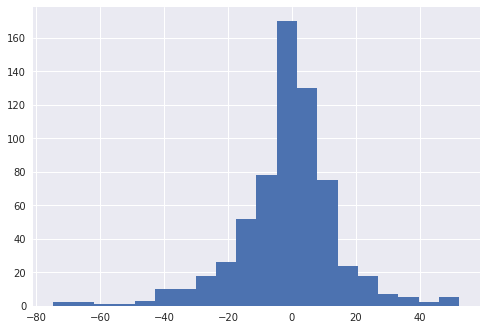

In [27]:
df_eval['error'] = df_eval['predicted'] - df_eval['target']
_ = plot.hist(df_eval['error'], bins=20)

In [28]:
%file {workspace_path}/data/prediction.csv
SERIALNO,AGEP,COW,ESP,ESR,FOD1P,HINS4,INDP,JWMNP,JWTR,MAR,POWPUMA,PUMA,RAC1P,SCHL,SCIENGRLP,SEX,WKW
490,64,2,0,1,0,2,8090,015,01,1,00590,00500,1,18,0,2,1
1225,32,5,0,4,5301,2,9680,015,01,1,00100,00100,1,21,2,1,1
1226,30,1,0,1,0,2,8680,020,01,1,00100,00100,1,16,0,2,1

Writing /content/datalab/workspace/census/data/prediction.csv


In [33]:
df_instances = pd.read_csv(os.path.join(workspace_path, 'data/prediction.csv'))
df_instances

,SERIALNO,AGEP,COW,ESP,ESR,FOD1P,HINS4,INDP,JWMNP,JWTR,MAR,POWPUMA,PUMA,RAC1P,SCHL,SCIENGRLP,SEX,WKW
0,490,64,2,0,1,0,2,8090,15,1,1,590,500,1,18,0,2,1
1,1225,32,5,0,4,5301,2,9680,15,1,1,100,100,1,21,2,1,1
2,1226,30,1,0,1,0,2,8680,20,1,1,100,100,1,16,0,2,1


In [34]:
df_predictions = regression.predict(training_dir=training_path, data=df_instances)
df_predictions

INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/model/variables/variables


,SERIALNO,predicted
0,490,23.645187
1,1225,54.794521
2,1226,12.918388


In [35]:
df_instances.set_index(keys=['SERIALNO'], inplace=True)
df_predictions.set_index(keys=['SERIALNO'], inplace=True)

df_data = df_predictions.join(other=df_instances)
df_data

,predicted,AGEP,COW,ESP,ESR,FOD1P,HINS4,INDP,JWMNP,JWTR,MAR,POWPUMA,PUMA,RAC1P,SCHL,SCIENGRLP,SEX,WKW
SERIALNO,,,,,,,,,,,,,,,,,,
490,23.645187,64,2,0,1,0,2,8090,15,1,1,590,500,1,18,0,2,1
1225,54.794521,32,5,0,4,5301,2,9680,15,1,1,100,100,1,21,2,1,1
1226,12.918388,30,1,0,1,0,2,8680,20,1,1,100,100,1,16,0,2,1
